# Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/mnt/drive', force_remount=True)

import pathlib
data_home = pathlib.Path('/mnt/drive/MyDrive/PROBE data')
for path in data_home.iterdir():
    print(path.name)

Mounted at /mnt/drive
systems_by_benchmarks.pkl
agged.pkl
benchmarks_by_features.pkl


In [ ]:
import pandas as pd
import itertools
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             explained_variance_score)
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from itertools import cycle
import warnings
from sklearn.linear_model import lasso_path, enet_path
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(style="whitegrid")

# Load the data

`agged_df` means "aggregated dataframe". It is aggregated across all collectors, all workloads, all iterations.

Each row is a particular collector, workload, and iteration. Keep this in mind: if we do 3 iterations of everything, we will need to groupby (collectors, workloads) and average the quantities of interest across iterations before doing anything else. In this dataset, I think we only have one iteration.

In [ ]:
agged_df = (
    pickle.loads((data_home / 'agged.pkl').read_bytes())
    # Let's drop everything except for walltime_mean.
    # The other columns are just noise, right now.
    [['walltime_mean']]
    .assign(**{
        "slowdown": lambda df: df["walltime_mean"] - df.loc["noprov"]["walltime_mean"],
        "overhead": lambda df: df["walltime_mean"] / df.loc["noprov"]["walltime_mean"],
    })
)
agged_df

walltime_mean   slowdown  overhead
collector workload                                      
PROBE     0                8.232737  -0.368696  0.957135
          acmart           1.759632   0.310023  1.213866
          all              2.227824   0.430923  1.239815
          apache           2.749310   0.965835  1.541547
          bw_file_rd       1.496472   0.825198  2.229302
...                             ...        ...       ...
strace    shell-incr       1.622472   0.120751  1.080409
          simplehttp      84.389397  62.993702  3.944223
          stat             3.644848  -0.063711  0.982820
          true             0.021467   0.002641  1.140266
          write            3.817480   0.156740  1.042816

[138 rows x 3 columns]

This dataframe is about the benchmarks; simply what syscalls do they contain. Yes, it was derived from the strace run, but it should be applicable to any run.

In [ ]:
benchmarks_by_syscalls = pickle.loads((data_home / "benchmarks_by_features.pkl").read_bytes())
benchmarks_by_syscalls

,mkdir,ftruncate,readlink,pipe2,openat,dup2,connect,unlink,vfork,exit_group,...,fchmod,fstat,clone3,utimensat,dup,creat,close,bind,newfstatat,rename
workload,,,,,,,,,,,,,,,,,,,,,
0,14,0,15,31,15364,23,80,7,22,13,...,0,0,25,0,9,0,10462,19,42181,0
acmart,0,0,2,0,4724,2,6,4,0,2,...,0,0,0,0,0,0,4582,0,8469,0
all,0,0,0,0,149958,1,2,50466,0,2,...,0,0,0,0,0,0,149929,0,149959,0
apache,0,0,4,6,1300392,0,1433,0,8,5,...,0,2,45,0,0,0,103058,173,101442,1
bw_file_rd,0,0,0,4,30,0,0,0,0,2,...,0,0,0,0,0,0,30,0,24,0
bw_pipe,0,0,0,5,29,0,0,0,0,2,...,0,0,0,0,0,0,26,0,24,0
bw_unix,0,0,0,5,29,0,0,0,0,2,...,0,0,0,0,0,0,33,0,24,0
catch-signal,0,0,0,8,56,0,0,0,0,3,...,0,0,0,0,0,0,44,0,42,0
cd,0,0,3,2,67,2,2,0,0,3,...,0,0,0,0,0,0,35,0,13000063,0


If the indexes of both dataframes go in the same order, we can combine the dataframes later on without having to do joins.

In [ ]:
assert (benchmarks_by_syscalls.index == agged_df.index.levels[1]).all()

# Examine syscalls

I will use expert knowledge to group the syscalls into categories.

In [ ]:
syscall_groups = {
    "network": {"accept", "bind", "shutdown", "accept4", "connect"},
    "chdirs": {"chdir"},
    "process": {"clone3", "exit_group", "clone", "vfork", "exit"},
    "execs": {"execve"},
    "read_inode": {"newfstatat", "access", "fstat", "readlink"},
    "modify_inode": {"mkdir", "rename", "utimensat", "rmdir", "symlink", "unlink", "link", "symlinkat", "fchmod", "mkdirat", "chmod"},
    "fd": {"dup2", "dup3", "pipe2", "close", "close_range", "dup"},
    "file": {"ftruncate", "openat", "creat"},
}
unclassified_syscalls = set(benchmarks_by_syscalls.columns) - set(itertools.chain.from_iterable(syscall_groups.values()))
assert not unclassified_syscalls, unclassified_syscalls


In [ ]:
benchmarks_by_syscall_group = pd.DataFrame.from_records({
      group_name: benchmarks_by_syscalls.loc[:, list(group_members)].sum(axis=1)
      for group_name, group_members in syscall_groups.items()
})

# For ease of viewing, show the most "interesting" (having more non-zeros) syscall groups first.
benchmarks_by_syscall_group = benchmarks_by_syscall_group[sorted(
    benchmarks_by_syscall_group.columns,
    key=lambda col: (benchmarks_by_syscall_group[col] != 0).sum(),
    reverse=True,
)]

All syscall groups for all workloads (table). Note that cd has a really high `chdir` count compared to the others and it has a significant `rel_slowdown` compared to the others. ML algorithms my overfit and associate `cd_syscalls` with `rel_slowdown`, but we know that `chdir` probably have little impact on performance compared to "real" file I/O syscalls.

The solution is to gather more benchmarks that use `cd`.

In [ ]:
pd.merge(
    agged_df.loc["PROBE"][["slowdown"]],
    benchmarks_by_syscall_group,
    left_index=True,
    right_index=True,
).sort_values(
    # For ease of viewing, show the benchmarks that hammer syscall group X first.
    list(benchmarks_by_syscall_group.columns),
    ascending=False,
)

,slowdown,execs,fd,file,process,read_inode,network,modify_inode,chdirs
workload,,,,,,,,,
exec,17.528919,10563,10597,56,21124,44,0,0,0
git_setuptools_scm,1.667422,1763,128440,209732,3526,378696,10574,20373,1763
hello-bin,-0.480901,1003,7025,10040,2004,8054,2,0,0
ps,-0.288329,1002,44024,82040,2003,68055,2002,0,0
ls,0.387940,1002,11024,29040,2004,21052,2,0,0
hg_schema-validation,1.771581,511,113378,123922,1693,462245,682,4393,1
git_strace_500,1.594793,502,47608,72231,22013,3674770,3002,6936,501
0,-0.368696,107,10525,15364,73,42222,107,23,1
lftp,1.101930,42,2747,1988,80,2706,115,69,11


This shows each workload and which syscall groups of interest it uses (red).
Note that some benchmarks don't use any syscall from groups of interest (e.g., getppid). This is expected since getppid just calls `getppid`, which is a syscall, but not an interesting group, since we don't log that.

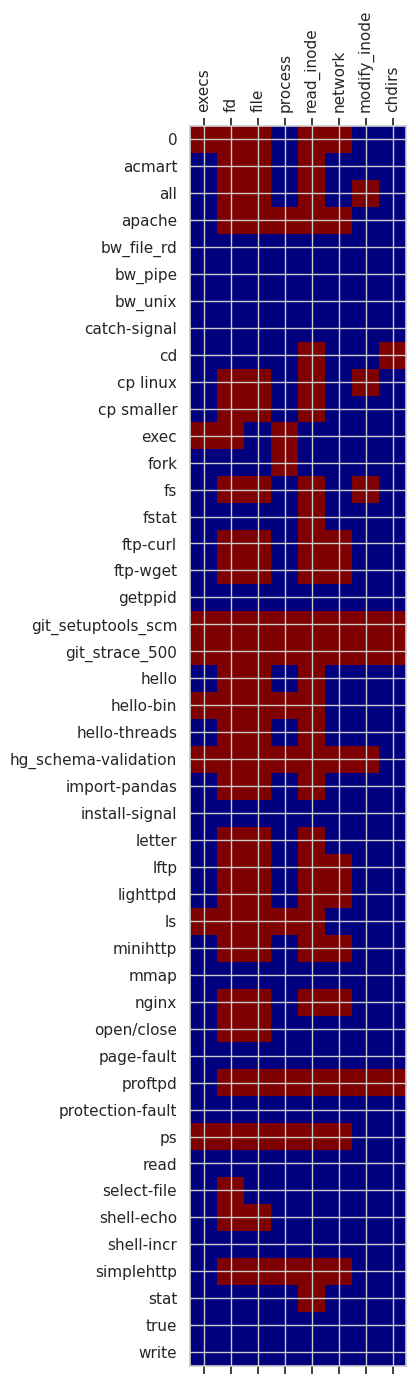

In [ ]:
plt.matshow(
    np.asarray((benchmarks_by_syscall_group > 100)),
    cmap="jet",
)
plt.xticks(
    range(len(benchmarks_by_syscall_group.columns)),
    benchmarks_by_syscall_group.columns,
    rotation="vertical",
)
plt.yticks(
    range(len(benchmarks_by_syscall_group.index)),
    benchmarks_by_syscall_group.index,
)
None

This graph shows how many benchmarks use a given syscall from a particular group more than 100 times. Note that cd_syscalls is rarely used, so it will be difficult to estimate.

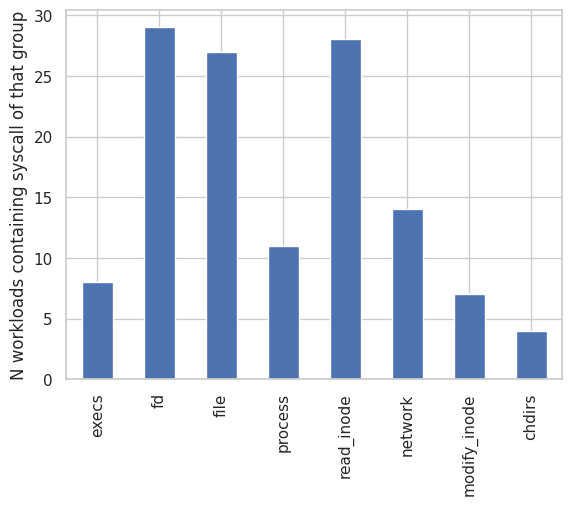

In [ ]:
(benchmarks_by_syscall_group > 100).sum().plot.bar()
plt.ylabel("N workloads containing syscall of that group")
None

The same graph, but for ungrouped syscalls.

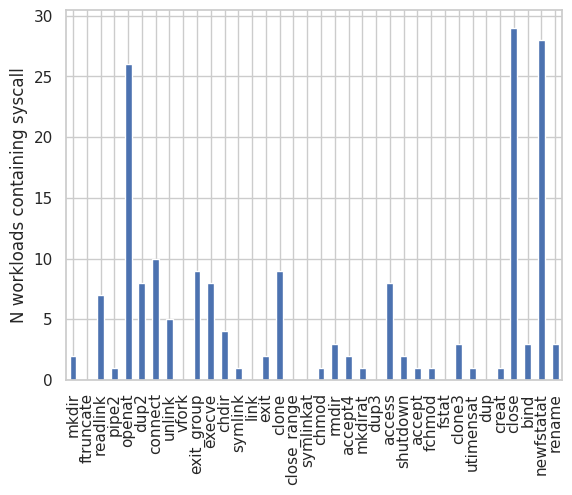

In [ ]:
(benchmarks_by_syscalls > 100).sum().plot.bar()
plt.ylabel("N workloads containing syscall")
None

# Removing outliers

I don't remove outliers lightly; read on for the **non-data** related reasons I justify removing some benchmarks (for now).

As we saw in the last section, `cd` is anomalous, until we add more benchmarks with `chdir` syscall, so I will remove it too.

In [ ]:
sample = ('PROBE', 'cd')
if sample in agged_df.index:
    agged_df = agged_df.drop(index=sample)

If the PROBE version is 20% faster than the original (overhead <= 0.8), it's probably a crash in PROBE. I spot-checked simplehttp, and confirmed. I am too lazy to check the others.

Remember, overhead is multiplicative (prov / noprov), while slowdown is subtractive (prov - noprov).

In the future, I will have the benchmark runner "fail noisily" when the benchmark crashes.

In [ ]:
threshold = 0.8
weird_outliers = agged_df[agged_df["overhead"] < threshold]
weird_outliers

walltime_mean    slowdown  overhead
collector workload                                        
PROBE     bw_unix           3.389515  -29.679796  0.102497
          hello             0.305752   -0.187675  0.619650
          hello-bin         1.546634   -0.480901  0.762815
          proftpd           5.728752  -15.045538  0.275762
          select-file       4.751127 -369.790368  0.012685
          simplehttp        2.011339  -19.384357  0.094007
strace    bw_unix           3.976730  -29.092580  0.120254
          hello-bin         1.377921   -0.649614  0.679604

In [ ]:
agged_df = agged_df[agged_df["overhead"] >= threshold]

The other negatives seem more reasonable (8.6 sec noprov &rarr; 8.5 PROBE) seems more like random variation in runtime. They still don't represent actual speedup, but I think they can be safely considered noise in the signal.

In [ ]:
(
    agged_df
    .loc["PROBE"]
    .assign(noprov_walltime_mean=agged_df.loc["noprov"]["walltime_mean"])
    .sort_values("slowdown")
    .head(10)
)

,walltime_mean,slowdown,overhead,noprov_walltime_mean
workload,,,,
0,8.232737,-0.368696,0.957135,8.601433
ps,2.640192,-0.288329,0.901544,2.928521
read,3.569274,-0.151970,0.959162,3.721243
getppid,3.557116,-0.113140,0.969174,3.670257
shell-incr,1.418180,-0.083541,0.944370,1.501721
fs,2.265133,-0.081777,0.965155,2.346910
minihttp,41.771557,-0.036182,0.999135,41.807738
lighttpd,0.577585,-0.018263,0.969350,0.595848
cp smaller,0.056368,0.006292,1.125661,0.050075


All of those that have really low slowdown ("hello", "ps", "read") are not doing the syscalls that are expensive for PROBE, so the result seems reasonable.

In [ ]:
(
    agged_df
    .loc["PROBE"]
    .assign(noprov_walltime_mean=agged_df.loc["noprov"]["walltime_mean"])
    .sort_values("slowdown")
    .tail(10)
)

,walltime_mean,slowdown,overhead,noprov_walltime_mean
workload,,,,
bw_file_rd,1.496472,0.825198,2.229302,0.671274
apache,2.749310,0.965835,1.541547,1.783475
ftp-wget,5.819176,1.038770,1.217298,4.780406
ftp-curl,5.764939,1.076420,1.229586,4.688519
lftp,5.771302,1.101930,1.235991,4.669371
git_strace_500,11.633254,1.594793,1.158868,10.038461
git_setuptools_scm,14.065709,1.667422,1.134488,12.398287
hg_schema-validation,29.259557,1.771581,1.064449,27.487976
exec,21.239815,17.528919,5.723636,3.710896


# Table for Walltimes

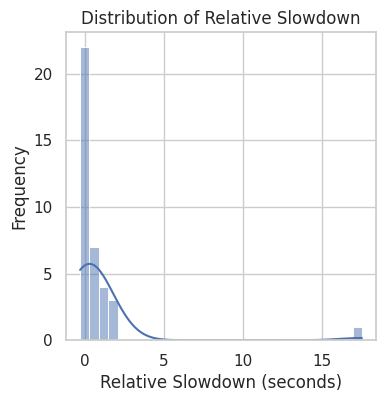

Descriptive Statistics for 'slowdown':
count    37.000000
mean      0.826201
std       2.871635
min      -0.288329
25%       0.027992
50%       0.161209
75%       0.585343
max      17.528919
Name: slowdown, dtype: float64


In [ ]:
#checking the distribution of relative slowdown
lower_bound = agged_df.loc["PROBE"]['slowdown'].quantile(0.01)
upper_bound = agged_df.loc["PROBE"]['slowdown'].quantile(0.99)
df = agged_df.loc["PROBE"]["slowdown"]
df = df[(df <= upper_bound) & (df >= lower_bound)]

plt.figure(figsize=(4, 4))
sns.histplot(df, bins=30, kde=True)
plt.title('Distribution of Relative Slowdown')
plt.xlabel('Relative Slowdown (seconds)')
plt.ylabel('Frequency')
plt.show()

print("Descriptive Statistics for 'slowdown':")
print(df.describe())

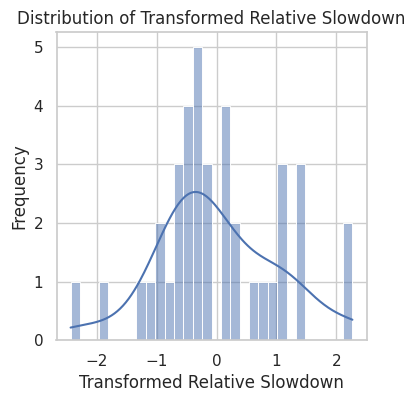

Descriptive Statistics for 'rel_slowdown_transformed':
count    3.900000e+01
mean    -8.540177e-18
std      1.013072e+00
min     -2.441552e+00
25%     -5.560036e-01
50%     -1.650630e-01
75%      7.134367e-01
max      2.270443e+00
dtype: float64


In [ ]:
pt = PowerTransformer(method='yeo-johnson')
df = pd.Series(pt.fit_transform(agged_df.loc["PROBE"]["slowdown"].values.reshape(-1, 1)).flatten())

plt.figure(figsize=(4,4))
sns.histplot(df, bins=30, kde=True)
plt.title('Distribution of Transformed Relative Slowdown')
plt.xlabel('Transformed Relative Slowdown')
plt.ylabel('Frequency')
plt.show()
print("Descriptive Statistics for 'rel_slowdown_transformed':")
print(df.describe())

# Model selection

Let the count of syscall A is $c_A$, of B is $c_B$, the relative slowdown is $s$, then the goal is to learn non-negative $x_0$, $x_A$, and $x_B$ such that $$s \approx x_0 + C_a x_A + C_b x_B.$$

The Y-intercept, $x_0$ represents a fixed-cost (in seconds) you pay for loading the provenance tracer itself, while $x_A$ represents the cost (in seconds) of a syscall A.

We will test out whether we should combine all syscalls, combine related ones into groups, or treat them individually.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV

estimators = {
    # We use non-negative linear estimators because the cost of each syscall is necessarily positive.
    # I had the "unconstrained" version of linear regression in here as a "safety check".
    # Since it is reliably preforming worse (as expected) than the non-negative on,
    # save yourself some time and CPU cycles and comment them out.

    # "linear": LinearRegression(
    #     fit_intercept=True,
    #     n_jobs=-1,
    # ),
    "nonneg-linear": LinearRegression(
        fit_intercept=True,
        positive=True,
        n_jobs=-1,
    ),

    # Elasticnet is like Linear regression, but it includes "regularization",
    # so it tries to ignore as many inputs as it can, while maintaining a certain amount of accuracy.
    # The tradeoff between accuracy and parsimony is determined by alpha, which we will sweep over in log-space.
    # It uses "inner" cross-validation to determine which alpha is best for your data.
    # I say "inner", because we will use "outer" cross-validation to determine its accuracy on the sample.
    # One of the assumptions/requirement of cross-validation is that the model is _only_ allowed to "see" the training data.
    # If information leaks from the test data to the train data, the "outer" cross-validation will not give the correct result.
    # So within just the training data, ElasticNetCV does an "inner" cross-validation to search for the best alpha.
    # It then makes a choice and gets graded on that choice by the "outer" cross-validation.

    # Likewise, we comment out the non-non-negative version.
    # The non-negative version is better.

    # "enet": ElasticNetCV(
    #     alphas=np.logspace(-12, 12, 100),
    #     l1_ratio=[0.1, 0.5, 0.9],
    #     fit_intercept=True,
    #     cv=5,
    #     random_state=42,
    #     n_jobs=-1,
    #     positive=False,
    # ),
    "nonneg-enet": ElasticNetCV(
        alphas=np.logspace(-12, 12, 100),
        l1_ratio=[0.1, 0.5, 0.9],
        fit_intercept=True,
        cv=5,
        random_state=42,
        n_jobs=-1,
        positive=True,
    ),
}

from sklearn.model_selection import cross_validate

scores = [
    # While these methods optimize MSE, I think MAE reflects the error we would actually get in practice.
    "neg_mean_absolute_error",
    #"neg_mean_squared_error",
    #"r2",
    #"explained_variance",
]

collectors = ["strace", "PROBE"]

benchmarks_by_total_syscalls = benchmarks_by_syscalls.sum(axis=1).to_frame("total_syscalls")

infos = []

for collector in collectors:
    # 3-way merge of features
    df = pd.merge(
        pd.merge(
            benchmarks_by_total_syscalls,
            benchmarks_by_syscall_group,
            left_index=True,
            right_index=True,
        ),
        benchmarks_by_syscalls,
        left_index=True,
        right_index=True,
    )

    df = df.loc[
        # Since we discarded outliers and the tests may not have run completely,
        # not every collector has every workload
        # so we apply .loc[workloads_you_actually_have]
        agged_df.loc[collector].index
    ]

    datas = {
        "total": (
            ["total_syscalls"],
            df[["total_syscalls"]],
        ),
        "total+execs": (
            ["total_syscalls", "execs"],
            df[["total_syscalls", "execs"]],
        ),
        "total+execs+procs": (
            ["total_syscalls", "execs", "process"],
            df[["total_syscalls", "execs", "process"]],
        ),
        "total+groups": (
            ["total_syscalls", "execs", "process"],
            df[["total_syscalls", "execs", "process"]],
        ),
        "groups": (
            [*sorted(benchmarks_by_syscall_group.keys())],
            df[sorted(benchmarks_by_syscall_group.keys())],
        ),
        # Individual syscalls is way to many, and linear regression can't handle it.
        # ElasticNet only does slightly better.
        #"individual": (
        #    [*sorted(benchmarks_by_syscalls.keys())],
        #    df[sorted(benchmarks_by_syscalls.keys())],
        #),
    }
    y = np.asarray(agged_df.loc[collector]['slowdown'])

    for data_name, (feature_names, data_X) in datas.items():
        for est_name, est in estimators.items():
            cv_scores = cross_validate(
                est, data_X, y,
                scoring=scores,
                # parallelism!
                n_jobs=-1,
            )
            score_val = -cv_scores["test_neg_mean_absolute_error"].mean()
            print(f"{collector:10s} {est_name:15s} {data_name:20s} {'mean absolute error':25s} {score_val: 6.1f}sec")
            try:
                r = est.fit(data_X, y)
            except RuntimeError as exc:
                print("No soln")
            else:
              for feature_name, coeff in zip(["intercept", *feature_names], [est.intercept_, *est.coef_]):
                  if np.fabs(coeff * 1e9) > 10:
                      print(f"{collector:10s} {est_name:15s} {data_name:20s} {feature_name:25} {int(coeff*1e9): 14,d} nanosec")
              if hasattr(r, "alpha_"):
                  print(f"{collector:10s} {est_name:15s} {data_name:20s} {'log(alpha)':25s} {np.log10(r.alpha_): 3.1f}")
            print()

for info in infos:
  print(info)

strace     nonneg-linear   total                mean absolute error          7.7sec
strace     nonneg-linear   total                intercept                  1,041,247,343 nanosec
strace     nonneg-linear   total                total_syscalls                    16,737 nanosec

strace     nonneg-enet     total                mean absolute error          9.2sec
strace     nonneg-enet     total                intercept                  1,041,247,343 nanosec
strace     nonneg-enet     total                total_syscalls                    16,737 nanosec
strace     nonneg-enet     total                log(alpha)                -8.6

strace     nonneg-linear   total+execs          mean absolute error          7.7sec
strace     nonneg-linear   total+execs          intercept                  1,041,247,343 nanosec
strace     nonneg-linear   total+execs          total_syscalls                    16,737 nanosec

strace     nonneg-enet     total+execs          mean absolute error          9.2sec


**The takeaways from the previous cell** are that for **strace**, nonneg-linear using the total number of syscalls is a pretty good estimator. It estimates the overhead = 1sec + 16us per syscall (any kind).

For **PROBE**, nonneg-linear using just the total is best. Total is better than total+execs which is better than everything else. It is possible that the execs will help us predict later, but our current dataset does not have enough data to train the model accurately. The estimator is that PROBE slowdown = 1.5 seconds, unconditionally. With more data, I expect we will be able to improve this to take into account the number of syscalls or execs.

It seems that the regularization done in ElasticNet, even when optimized in cross-validation, is unnecessary for this dataset. I think it doesn't have enough variables to _need_ regularization, and applying parsimony by hand-selecting variables with knowledge of the domain is better than ElasticNet.

Interesting workloads are defined as workloads where the PROBE and strace overheads are very different. It would be too hard to plot _all_ of the data, so I will only plot the interesting workloads.

In [ ]:
interesting_workloads = list(
    pd.merge(
      agged_df.loc["PROBE"],
      agged_df.loc["strace"],
      left_index=True,
      right_index=True,
      suffixes=["_probe", "_strace"],
    )
    .dropna()
    .assign(diff=lambda df: np.fabs(df["walltime_mean_probe"] - df["walltime_mean_strace"]))
    .sort_values("diff", ascending=False)
    .head(10)
    .index
)
interesting_workloads

['hg_schema-validation',
 'git_strace_500',
 'nginx',
 'exec',
 'git_setuptools_scm',
 'shell-echo',
 'all',
 'apache',
 'cp linux',
 'lighttpd']

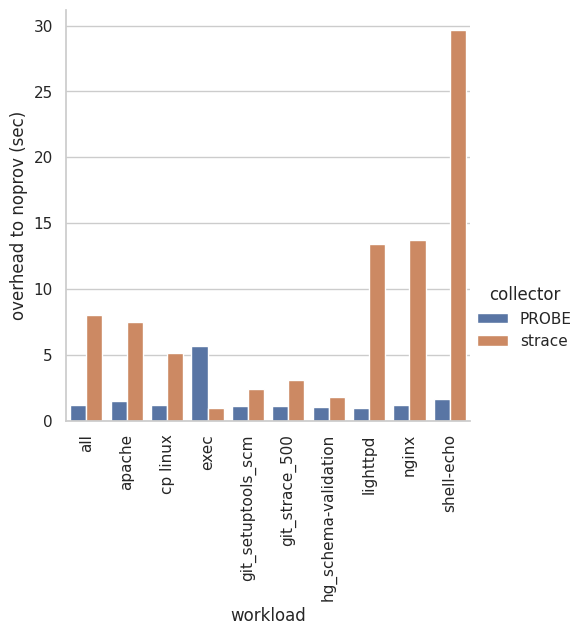

In [ ]:
import seaborn as sns

interesting_data = (
    agged_df
    .loc[["PROBE", "strace"]]
    .reset_index()
    [lambda df: df["workload"].isin(interesting_workloads)]
    .assign(
        collector=lambda df: df.collector.cat.remove_unused_categories(),
        workload=lambda df: df.workload.cat.remove_unused_categories(),
    )
)

ax = sns.catplot(
    data=interesting_data,
    x="workload",
    y="overhead",
    hue="collector",
    kind="bar",
)
ax.set(ylabel="overhead to noprov (sec)")
ax.tick_params(axis='x', labelrotation=90)

# Variable importance

Even though we will likely use linear regression without ElasticNet, ElasticNet can tell you which variables "matter" the most given a certain requirement for parsimony.

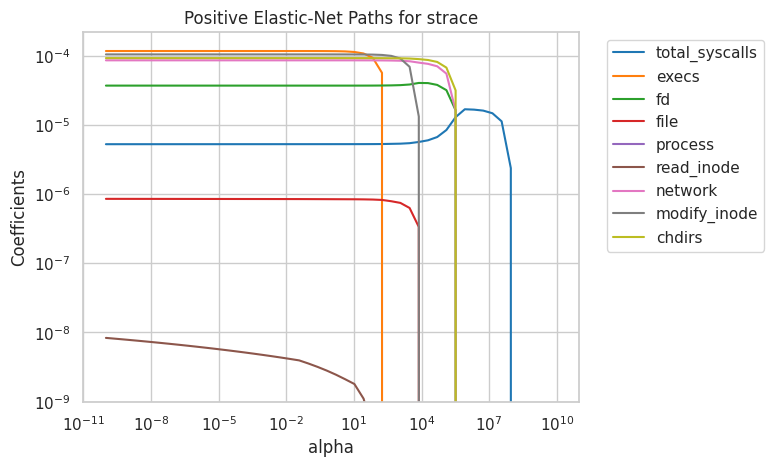

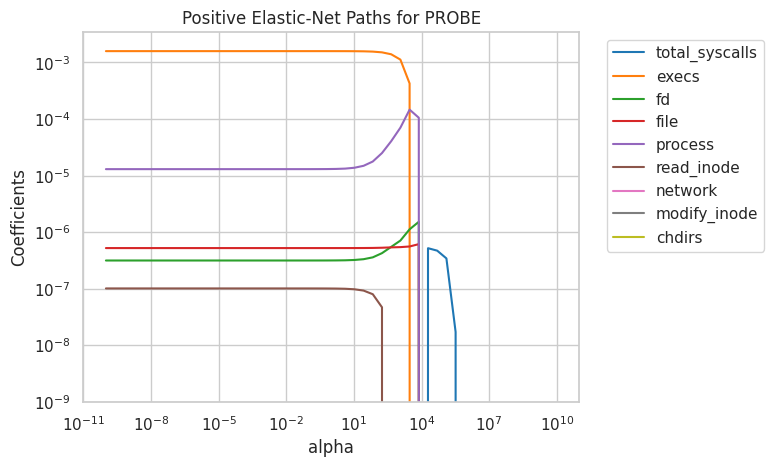

In [ ]:
# See https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py
X = pd.merge(
    benchmarks_by_total_syscalls,
    benchmarks_by_syscall_group,
    left_index=True,
    right_index=True,
)
for collector in collectors:
    y = agged_df.loc[collector]['slowdown']
    alphas_positive_enet, coefs_positive_enet, _ = enet_path(
        X.loc[agged_df.loc[collector].index],
        y,
        l1_ratio=0.9,
        alphas=np.logspace(-10, 10, 50),
        positive=True,
    )
    plt.figure(1)
    for coef_e, c, label in zip(coefs_positive_enet, plt.cm.tab10.colors * 3, X.columns):
        l2 = plt.loglog(alphas_positive_enet, coef_e, c=c, label=label)

    plt.xlabel("alpha")
    plt.ylabel("Coefficients")
    plt.title(f"Positive Elastic-Net Paths for {collector}")
    plt.axis("tight")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.ylim(1e-9, plt.ylim()[1])
    plt.show()


This graph shows how the coefficients of the feautures change with $\alpha$, which determines how much to trade-off accuracy with parsimony. At the left, when we prioritize accuracy, almost all of the syscall groups have non-zero coefficients. Towards the middle-right, they get "replaced" by the `total_syscalls`. When you want a more parsimonious model, only have 1 variable: total syscalls. At the far right, it's just the Y-intercept (0 variables).

It's kind of interesing how the syscalls are different towards the left. In strace, it seems that most of the syscall groups cost $10^{-4}$, but some are cheaper?? That's interesting. For PROBE, execs cost the most, followed by process-related syscalls (fork, clone, exit, etc.).